In [1]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind
import statsmodels.api as sm

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
#import ptitprince as pt

# Set the default plots style
sns.set_theme(style="white")

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

# Set the default tick_params options for all axes
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = False
mpl.rcParams['ytick.direction'] = 'out'


def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign=''
    return sign

## Mean effect

In [72]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query("(game1_fmri>=0.5)")
# Sort the data on the 'game1_acc' column
data = data.sort_values(by='game1_acc',ascending=False)
data['acc_binary'] = data['game1_acc'].apply(lambda x: 1 if x > 0.8 else 0)
subjects = data['Participant_ID'].to_list()

# set camp
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_diff/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_diff/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_zmap.nii.gz'
# cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/grid_rsa/Setall/6fold/{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
sub_cmap_paths = [cmap_template.format(sub_id) for sub_id in subjects]

# set roi
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
# roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob_L.nii.gz')
# roi = image.binarize_img(roi,5)
roi  = mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/lh.isthmuscingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/rh.isthmuscingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/PCC/PCCk3_MNI152Nl.nii.gz')
#lh.lateralorbitofrontal.nii.gz
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-lRSC.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-rRSC.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/Rsp_bilat_Yeo.nii.gz')
# roi = image.resample_to_img(roi,sub_cmap_paths[0],interpolation='nearest')
# roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/lRSC_thr3.1_erosion.nii.gz')
thr = 0
roi_thr = image.binarize_img(roi, thr)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [73]:
# Compute mean activity
subs_mean_activity = np.mean(masking.apply_mask(sub_cmap_paths, roi_thr), axis=1)
act_data = pd.DataFrame({'sub':[0]*len(subjects), 'mean_act':subs_mean_activity,'performance':data['acc_binary']})
# statistical tests
t_statistic, p_value = ttest_1samp(subs_mean_activity, 0)
#print('thr: {}'.format(thr))
print('t:', t_statistic)
print('p:', p_value)

t: 4.289788892550297
p: 2.7714073851298496e-05


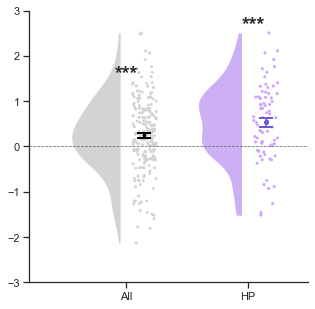

In [74]:
fig,ax = plt.subplots(figsize=(5,5))

all_sub = act_data['mean_act']
hp_sub = act_data[act_data['performance'] == 1]['mean_act']

data = pd.DataFrame({'All':all_sub,'HP':hp_sub})
pt.RainCloud(data=data, orient='v',linewidth=0,palette=['lightgray','#cca3ff'],scale='area',width_viol=0.8,bw = 0.35,move=0.15,offset=0.05)

# Create error bar
mean, se = all_sub.mean(),all_sub.sem()
plt.errorbar(x=0.15, y=mean, yerr=se, color='black', fmt='o',capsize=7,capthick=2,markersize=3)
t1, p1 = ttest_1samp(subs_mean_activity, 0)
plt.text(0, mean+20*se, p2sign(p1),ha='center', va='bottom',weight='bold',size=20)

mean, se = hp_sub.mean(), hp_sub.sem()
plt.errorbar(x=1.15, y=mean, yerr=se, color='slateblue', fmt='o',capsize=7,capthick=2,markersize=4)
plt.hlines(y=0, xmin=-1, xmax=1.5, color='dimgray',linestyle='--',linewidth=0.75)

t2, p2 = ttest_1samp(act_data[act_data['performance'] == 1]['mean_act'], 0)
plt.text(1.05, mean+20*se, p2sign(p2),ha='center', va='bottom',weight='bold',size=20)

ax.set_xlim(-0.8,1.5)
ax.set_ylim(-3,3)
plt.savefig("/mnt/workdir/DCM/Result/paper/figure3/VMPFC/Distance_VMPFC_Mean_.pdf", dpi=300, bbox_inches='tight',pad_inches=0,transparent=True)

## Plot ROI covairate effect

In [19]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("(game2_fmri>=0.5)")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexModdistance_spct/Setall/6fold/' \
#                 r'{}/zmap/hexModdistance_zmap.nii.gz'
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'

# load roi
# roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)

# roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/vmPFC_bin.nii.gz')
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/lRSC_thr3.1_erosion.nii.gz')
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
# 
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.posteriorcingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.posteriorcingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/EC_thr3.1.nii.gz')
roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,5)
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/dmPFC_closed_dilated_resampled.nii.gz')
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/Park_Grid_ROI/mPFC_GP_roi.nii')

# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


r -0.0082 p 0.91


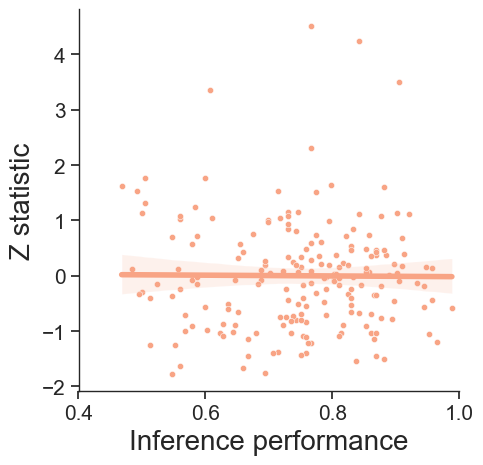

In [23]:
# get covariate
participants_data['beh_diff'] = participants_data['game2_test_acc'] - participants_data['game1_acc']

covariate = 'Acc'
# Setup variables based on covariate
if covariate == 'Age':
    color = '#e36570'
    covary_variable = participants_data['Age'].to_list()
    xlabel = 'Age'
    ticks = [8, 12, 16, 20, 24]
    xlim = [7,26]
elif covariate == 'Acc':
    color = '#F8A485'
    covary_variable = participants_data['game1_acc'].to_list()
    xlabel = 'Inference performance'
    ticks = [0.4,0.6,0.8,1.0]
else:
    raise ValueError("Invalid covariate value")

# Standardize subs_mean_activity
subs_mean_activity = (np.array(subs_mean_activity) - np.mean(subs_mean_activity)) / np.std(subs_mean_activity)

# Initialize the plot
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=covary_variable, y=subs_mean_activity, color=color, s=20, alpha=1)
sns.regplot(x=covary_variable, y=subs_mean_activity, color=color, order=1, scatter=False,line_kws={'linewidth': 4})

# Setup labels and despine
ax.set_xlabel(xlabel, fontsize=20)
ax.set_ylabel('Z statistic', fontsize=20)
sns.despine(top=True, right=True)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set ticks
if covariate == 'Age':
    plt.xlim([7,26])
#plt.ylim([-3, 3])
plt.yticks(size=15)
plt.xticks(ticks, size=15)

# Compute pearson correlation
r, p = pearsonr(covary_variable, subs_mean_activity)
print('r', round(r,4), 'p', round(p,4))

# Add title based on significance level
fig.subplots_adjust(top=0.92)
title = p2sign(p)
fig.suptitle(title, size=20, fontweight='bold')

# Set tick parameters
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')

# Uncomment the lines below if you want to save the figure
fig.tight_layout()
savepath = '/mnt/workdir/DCM/Result/paper/sf/sf5/Hexagon/HexModDistance_ROI-EC_{}.pdf'.format(covariate)
plt.savefig(savepath, bbox_inches='tight', pad_inches=0, dpi=300, transparent=True)

# Show the plot
plt.show()

## Partial correlation

In [20]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
task = 'game1'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query(f"{task}_fmri>=0.5")
subjects_id = data['Participant_ID'].to_list()

# set camp
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_zmap.nii.gz'
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/cmap/alignPhi_cmap.nii.gz'
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/' \
#                 r'{}/zmap/distance_zmap.nii.gz'
# 
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/' \
           r'{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'
# lhc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# rhc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=lhc, img2=rhc)
# set roi
roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,5)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
#roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/vmPFC_bin.nii.gz')
# lofc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/lh.lateralorbitofrontal.nii.gz') #parsorbitalis
# rofc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/rh.lateralorbitofrontal.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=lofc, img2=rofc)
#roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/PCC/PCCk3_MNI152Nl_bin.nii.gz')

# extract mean activity
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)
data['Activity'] = subs_mean_activity

subs_hm = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/head_motion/preprocessed_data_rms.csv')
subs_task = subs_hm[subs_hm['task']==task]
subs_task_fd_avg = subs_task.groupby("sub_id")['fd_mean'].mean()
sub_fd = [subs_task_fd_avg[sub_id] for sub_id in subjects_id]
data['fd'] = sub_fd

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/tmp/ipykernel_2430751/1761217605.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Activity'] = subs_mean_activity
/tmp/ipykernel_2430751/1761217605.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [23]:
#
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']
data['Age_demean'] = (data['Age'] - data['Age'].mean())
X = data[['Age','fd']]
Y = data['Activity']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)
# 
# # Save the summary to a text file
# #with open('/mnt/workdir/DCM/Result/paper/figure4/game2-hexagon_consistency_glm_model_summary.txt', 'w') as f:
# #    f.write(model_summary.as_text())
# 
# # Plot the partial correlation plot with age held constant
fig = sm.graphics.plot_partregress("game2_test_acc", "Activity", exog_others=['Age','game1_acc'], data=data,obs_labels=False)
# 
# fig.set_size_inches(5,5)
# sns.set_theme(style="white")
# fig.tight_layout()
# 
# # Get the Axes object
# ax = fig.get_axes()[0]
# # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# # Add tick lines to the bottom and left spines
# ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
# ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
# 
# # Set custom ticks for the x-axis and y-axis
# # plt.xticks([-2, -1, 0, 1, 2])
# # plt.yticks([-0.2, 0, 0.2])
# 
# # Change color of scatter points and line to 'salmon'
# for line in ax.lines:
#     line.set_color('#e36570')
#     line.set_linewidth(5)
# for path in ax.collections:
#     path.set_edgecolor('#e36570')           
# 
# ax.set_xlabel("Activity")
# ax.set_ylabel("beh_diff")
# 
# # Save the figure before calling fig.show()
# #fig.savefig('/mnt/workdir/DCM/Result/paper/figure4/game2-hexagon_consistency_partial_correlation_plot.pdf', dpi=300, bbox_inches='tight',pad_inches=0,transparent=True)
# fig.show()

                            OLS Regression Results                            
Dep. Variable:               Activity   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     8.671
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           0.000245
Time:                        11:43:23   Log-Likelihood:                -291.52
No. Observations:                 203   AIC:                             589.0
Df Residuals:                     200   BIC:                             599.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9977      0.401      2.491      0.0

/tmp/ipykernel_2430751/3063028599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']
/tmp/ipykernel_2430751/3063028599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age_demean'] = (data['Age'] - data['Age'].mean())


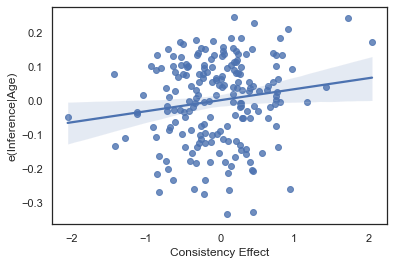

(0.14996218627753405, 0.03737960416515819)

In [197]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('Inference_acc ~ Age', data=data).fit()
results2 = smf.ols('Consistency_effect ~ Age', data=data).fit()
# Create a new DataFrame with the residuals
resid_data = pd.DataFrame({
    'consistency_effect': data['Consistency_effect'],
    'age_resid': results.resid_pearson,
    'inference_accuracy_resid': results.resid
})

# Plot the residuals against one another
sns.regplot(x='consistency_effect', y='inference_accuracy_resid', data=resid_data)
plt.xlabel('Consistency Effect')
plt.ylabel('Game2_test_acc')
plt.show()

pearsonr(resid_data['consistency_effect'], resid_data['inference_accuracy_resid'])

In [212]:
import pingouin as pg
pg.partial_corr(data,'Activity', 'beh_diff', covar=['Age'], method='pearson', alternative='greater')

,n,r,CI95%,p-val
pearson,193,0.144233,"[0.03, 1.0]",0.02297


## Plot brain activity with separate age stage

In [ ]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("game1_fmri>=0.5")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'


# set roi
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.parsorbitalis.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.parsorbitalis.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,5)
# roi = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')

# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

The group difference bettwen children and adolescents t = -1.025, p = 0.307
The group difference bettwen adolescents and adults t = -1.453, p = 0.149
The group difference bettwen children and adults t = -2.772, p = 0.006


Text(1, 0.6012360958294767, '**')

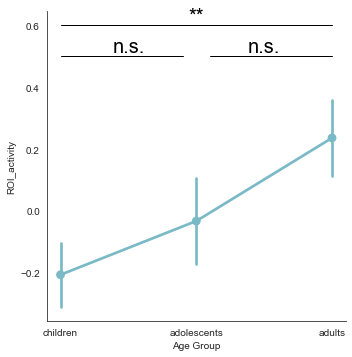

In [37]:
# zscore
subs_mean_activity = (np.array(subs_mean_activity) - np.mean(subs_mean_activity)) / np.std(subs_mean_activity)
participants_data['ROI_activity'] = subs_mean_activity

# Add age group categories
age_bins = [7, 12, 17, 25]
age_labels = ['children', 'adolescents', 'adults']
participants_data['Age_group'] = pd.cut(participants_data['Age'], bins=age_bins, labels=age_labels)

# Plotting
g = sns.catplot(x='Age_group', y='ROI_activity', data=participants_data, kind='point', errorbar="se",color='#7abac6')
g.set_axis_labels("Age Group", "ROI_activity")
g.fig.set_size_inches(5, 5)

# get the acivities of each age group
children_data = participants_data.query("Age_group=='children'")
adolescents_data = participants_data.query("Age_group=='adolescents'")
adult_data = participants_data.query("Age_group=='adults'")

# compare activity size between each pair of the three age groups using t-tests
height = participants_data['ROI_activity'].mean() + 0.5*participants_data['ROI_activity'].std()

# compare children and adolescents
t,p = ttest_ind(children_data['ROI_activity'], adolescents_data['ROI_activity'])
print('The group difference bettwen children and adolescents t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 0.9], [height, height], 'k-', lw=1)
g.ax.text(0.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare children and adults
t,p =  ttest_ind(adolescents_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen adolescents and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([1.1, 2], [height, height], 'k-', lw=1)
g.ax.text(1.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare adolescents and adults
t,p = ttest_ind(children_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen children and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 2], [height+0.1, height+0.1], 'k-', lw=1)
g.ax.text(1, height+0.1, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

## Test whether the difference between the correlation coefficients is significant

In [ ]:
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

# set
a1 = children_data['ROI_activity'].to_numpy()
b1 = children_data['game1_acc'].to_numpy()

a2 = adolescents_data['ROI_activity'].to_numpy()
b2 = adolescents_data['game1_acc'].to_numpy()

# get the correlation coefficients
r1,p1 = pearsonr(a1,b1)
r2,p2 = pearsonr(a2,b2)

# Sample sizes for each correlation coefficient
n1 = len(a1)
n2 = len(a2)
print(r1,p1)
print(r2,p2)

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

print(independent_corr(r1 , r2, n1, n2, method='fisher',twotailed=False))

# Mediation analysis

### Load data

In [13]:
# check whether the manhattan distance can predict/meidate value effect and inference accuracy

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game1_fmri>=0.5')  # look out
data['training_acc'] = (data['train_ap'] + data['train_dp'])/2

mean_accuracy_by_age = data.groupby('Age')['training_acc'].mean()
data['mean_accuracy_by_age'] = data['Age'].map(mean_accuracy_by_age)

subjects = data['Participant_ID'].to_list()

# set cmp template
rsa_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/' \
           r'{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'
#distance_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
#value_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'
#hexModdistance_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
#alignment_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/cmap/alignPhi_cmap.nii.gz'
#
sub_rsa_zmap = [rsa_zmap.format(sub) for sub in subjects]
#sub_distance_zmap = [distance_zmap.format(sub) for sub in subjects]
#sub_value_zmap = [value_zmap.format(sub) for sub in subjects]
#sub_hexModdistance_zmap = [hexModdistance_zmap.format(sub) for sub in subjects]
#sub_alignment_zmap = [alignment_zmap.format(sub) for sub in subjects]


ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,5)

mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_MNI152NL_new.nii.gz')
# lofc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/lh.lateralorbitofrontal.nii.gz') #parsorbitalis
# rofc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/rh.lateralorbitofrontal.nii.gz')
# ofc = image.math_img('np.logical_or(img1,img2)', img1=lofc, img2=rofc)
# lhc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# rhc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# hc = image.math_img('np.logical_or(img1,img2)', img1=lhc, img2=rhc)

# extract mean activity of ROI for each subjects
data['hexagon_EC'] =  np.mean(masking.apply_mask(sub_rsa_zmap, ec), axis=1)
# data['alignment_EC'] =  np.mean(masking.apply_mask(sub_alignment_zmap, ec), axis=1)
# data['distance_mpfc'] = np.mean(masking.apply_mask(sub_distance_zmap, mpfc), axis=1)
#data['value_mpfc'] = np.mean(masking.apply_mask(sub_value_zmap,mpfc), axis=1)
# data['hexModdistance_mPFC'] =  np.mean(masking.apply_mask(sub_hexModdistance_zmap, mpfc), axis=1)
# data['hexModdistance_lofc'] =  np.mean(masking.apply_mask(sub_hexModdistance_zmap, ofc), axis=1)
# data['hexModdistance_hc'] =  np.mean(masking.apply_mask(sub_hexModdistance_zmap, hc), axis=1)
#data['distance_ofc'] =  np.mean(masking.apply_mask(sub_distance_zmap ,ofc), axis=1)
#data['distance_hc'] =  np.mean(masking.apply_mask(sub_distance_zmap ,hc), axis=1)
#data['hexagon_mpfc'] = np.mean(masking.apply_mask(sub_hexagon_zmap, mpfc), axis=1)

/tmp/ipykernel_2430751/173040377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['training_acc'] = (data['train_ap'] + data['train_dp'])/2
/tmp/ipykernel_2430751/173040377.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mean_accuracy_by_age'] = data['Age'].map(mean_accuracy_by_age)
/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1065: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with num

### Multiple regression

In [31]:
# using GLM to predict inference accuracy from brain activity and age
X = data[['game2_test_acc','Age']]
Y = data['distance_mpfc']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# 将摘要保存到文件
# summary_file = '/mnt/workdir/DCM/Result/paper/figure3/Value/Value_mPFC-meidaiton-glm1_summary.txt'
# with open(summary_file, 'w') as f:
#     f.write(model_summary.as_text())
#     f.close()

                            OLS Regression Results                            
Dep. Variable:          distance_mpfc   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     29.94
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           4.97e-12
Time:                        15:42:33   Log-Likelihood:                -221.84
No. Observations:                 193   AIC:                             449.7
Df Residuals:                     190   BIC:                             459.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9490      0.351     -5.554      0.0

### Mediation analysis(A)

In [12]:
import pingouin as pg
from sklearn.preprocessing import StandardScaler
#data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']
iv = 'Age'
m = ['distance_mpfc','alignment_EC']
dv = 'game2_test_acc'

# Instantiate the StandardScaler
scaler = StandardScaler()

# fit the scaler to the columns and transform
data[['Age','alignment_EC','distance_mpfc','game2_test_acc','game1_acc']] = scaler.fit_transform(data[['Age','alignment_EC','distance_mpfc','game2_test_acc','game1_acc']])

# Mediation analysis
mediation_results,indirect_beta_sample = pg.mediation_analysis(data=data, x=iv, m=m, y=dv,covar=['game1_acc'],seed=42,n_boot=10000,return_dist=True)
print(mediation_results.round(3))

# # save results
# mediation_results.to_csv(r'/mnt/workdir/DCM/Result/paper/sf/sf3/Distance_mPFC_mediation.csv', index=False)
# np.save(r'/mnt/workdir/DCM/Result/paper/sf/sf3/Indirect_beta_sample_distance_mPFC.npy', indirect_beta_sample)

/tmp/ipykernel_2430751/2060673372.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Age','alignment_EC','distance_mpfc','game2_test_acc','game1_acc']] = scaler.fit_transform(data[['Age','alignment_EC','distance_mpfc','game2_test_acc','game1_acc']])


                     path   coef     se   pval  CI[2.5%]  CI[97.5%]  sig
0       distance_mpfc ~ X  0.224  0.075  0.003     0.075      0.373  Yes
1        alignment_EC ~ X -0.093  0.085  0.278    -0.262      0.076   No
2       Y ~ distance_mpfc  0.096  0.040  0.018     0.017      0.175  Yes
3        Y ~ alignment_EC  0.069  0.036  0.058    -0.002      0.140   No
4                   Total  0.130  0.043  0.003     0.046      0.214  Yes
5                  Direct  0.121  0.043  0.006     0.036      0.205  Yes
6  Indirect distance_mpfc  0.016  0.010  0.036     0.002      0.042  Yes
7   Indirect alignment_EC -0.007  0.007  0.278    -0.026      0.003   No


In [17]:
import pingouin as pg

pg.partial_corr(data=data, x='distance_mpfc', y='Age', covar='game1_acc', method='pearson')

,n,r,CI95%,p-val
pearson,193,0.402479,"[0.28, 0.51]",6.538640e-09


### Mediation analysis(B)

In [17]:
def bootstrap_indirect_effect(data, iv, m, dv, n_bootstraps=5000, ci=0.95):
    indirect_effects = []
    for _ in range(n_bootstraps):
        bootstrap_data = data.sample(frac=1, replace=True)

        path_a = smf.ols(f"{m} ~ {iv}", data=bootstrap_data).fit()
        path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=bootstrap_data).fit()

        indirect_effect = path_a.params[1] * path_b.params[1]
        indirect_effects.append(indirect_effect)

    lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
    upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

    return lower, upper,indirect_effects

# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'Age'
m = 'hexagon'
dv = 'game1_acc'

# Path a: IV -> M
path_a = smf.ols(f"{m} ~ {iv}", data=data).fit()

# Path b: M -> DV, controlling for IV
path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=data).fit()
lower, upper,indirect_effects = bootstrap_indirect_effect(data, iv, m, dv,5000)
print(f"Bootstrapped {int(0.95 * 100)}% confidence interval for the indirect effect: ({lower:.8f}, {upper:.8f})")

Bootstrapped 95% confidence interval for the indirect effect: (0.00341708, 0.07773135)


### Plot bootstrap distribution of indirect effect

mean: 0.03623399526694947
standard error: 0.019392967203741732


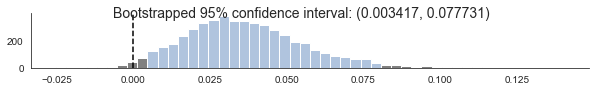

In [18]:
# Calculate lower and upper bounds
ci=0.95
lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)
print('mean:',np.mean(indirect_effects))
print('standard error:',np.std(indirect_effects))
# Plot histogram
fig, ax = plt.subplots(figsize=(10,1))
n, bins, patches = ax.hist(indirect_effects, color='gray',bins=50)

# Find the bin with the highest frequency and its corresponding height
max_height = max(n)
max_height_index = np.where(n == max_height)[0][0]
max_height_bin = bins[max_height_index]

# Add vertical line at zero with height equal to the maximum frequency
ax.axvline(x=0, ymin=0, ymax=max_height, color='black', linestyle='--')

# Color the histogram between the lower and upper bounds blue
for i in range(len(patches)):
    if lower <= bins[i] < upper:
        patches[i].set_fc('lightsteelblue')

# Remove top and right spines
fig.suptitle(f"Bootstrapped {int(ci * 100)}% confidence interval: ({lower:.6f}, {upper:.6f})",size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# savepath = r'/mnt/workdir/DCM/Result/paper/figure3/Value_vmpfc-meidaiton-age2inference.pdf'
# plt.savefig(savepath,bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)